# **Práctica 3**
Lucía Pazos Santiago, Anxo Trillo Santamaría, Javier Ares Vila

In [1]:
# Importaciones necesarias
try:
    import torch
    from torch.utils.data import DataLoader
    from torchvision import datasets
    from torchvision.transforms import ToTensor
    import torch.nn as nn
    import torch.nn.functional as F
except ImportError:
    !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    import torch
    from torch.utils.data import DataLoader
    from torchvision import datasets
    from torchvision.transforms import ToTensor
    import torch.nn as nn
    import torch.nn.functional as F
    
try:
    from skimage.feature import hog
    from skimage.color import rgb2gray
except ImportError:
    !pip3 install scikit-image
    from skimage.feature import hog
    from skimage.color import rgb2gray
!pip3 install matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix 
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torchvision.datasets import ImageFolder
import torchvision
from torchvision import transforms
import itertools

torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 10.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 5.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2


## Arquitectura MLP modular

In [8]:
class MLP(nn.Module):
    def __init__(self, input_neurons, output_neurons, hidden_layers):
        super(MLP, self).__init__()
        self.input_neurons=input_neurons
        self.output_neurons=output_neurons
        self.hidden_layers=hidden_layers

        self.flatten = nn.Flatten()

        layers=[]
        prev_neurons=input_neurons
        if isinstance(hidden_layers,list):
            for i in hidden_layers:
                layers.append(nn.Linear(prev_neurons,i))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(0.5))
                prev_neurons=i
        else:
            print("ERROR DE FORMATO, PASALE UNA LIST COMO HIDDENLAYERS")
        
        layers.append(nn.Linear(prev_neurons,output_neurons))

        self.hiddenlayer_stack = nn.Sequential(*layers)


    def forward(self, x):

        x=self.flatten(x)
        salida=self.hiddenlayer_stack(x)
        return salida

In [7]:
# Ejemplo de uso 

mlp = MLP(
    input_neurons=128*128*3,
    output_neurons=10,
    hidden_layers=[64,32]
)

def get_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"O modelo ten {get_parameters(mlp):,} parámetros")

O modelo ten 3,148,202 parámetros


## Arquitectura CNN modular

In [9]:
# Definición de la clase CNN
class CNN(nn.Module):

    # input_channels: número de canales de entrada 
    # conv_layers: número de capas convolucionales
    # first_conv_filters: num filtros primera capa, se duplicarán en cada capa
    # con_kernel_size: tam filtros convolucionales (cuadrados)
    # batch_norm: booleano para usar normalización por lotes
    # hidden_mlp_layers: número de neuronas en la capa oculta de la red MLP
    # output_neurons: número de neuronas de salida
    # input_size: tamaño de las imagenes que le vamos a pasar
    def __init__(self, input_channels, conv_layers, first_conv_filters, conv_kernel_size, batch_norm, hidden_mlp_layers, output_neurons,input_size):

        # Construtor 
        super(CNN, self).__init__()  

        def conv_size(size): #Funcion que calcula el tamaño resultante de la convolucion
            return (size - conv_kernel_size + 1) 

        def pool_size(size, kernel_size=2, stride=2, padding=0): #Funcion que calcula el tamaño resultante del pooling
            return (size - kernel_size + 2 * padding) // stride + 1

        current_channels = input_channels
        current_filters = first_conv_filters
        
        if isinstance(input_size,list): #Asumimos que las imágenes son cuadradas
            current_size = input_size[0]
        else:
            current_size=input_size

        # Arrays auxiliares
        layers = [] # Contiene las capas

        # Definición de capas según los parámetros
        for _ in range(conv_layers): # Bucle para el número de capas convolucionades pasadas por parámetro
            layers.append(nn.Conv2d(in_channels=current_channels, out_channels=current_filters, kernel_size=conv_kernel_size))
            current_size = conv_size(current_size) #Se calcula el tamaño resultante en una dimensión (el total sería size * size * channels)

            if batch_norm: # Si se usa normalización por lotes, se añade la capa de normalización
                layers.append(nn.BatchNorm2d(current_filters)) # Capa de normalización por lotes
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) # Capa de max pooling
            current_size = pool_size(current_size) #Se calcula el tamaño resultante en una dimensión (el total sería size * size * channels)

            layers.append(nn.ReLU()) # Capa de activación ReLU
            current_channels = current_filters # Actualiza el número de canales de entrada para la siguiente capa convolucional

            current_filters *= 2 # Duplica el número de filtros para la siguiente capa convolucional

        # Capa de convolución final
        self.conv = nn.Sequential(*layers) # Capa convolucional compuesta por las capas definidas en el bucle anterior
        
        # Capa de aplanamento
        self.flatten = nn.Flatten()

        # Cálculo del tamaño de la salida de la última capa convolucional
        flattened_size = current_channels * current_size * current_size 
        
        # MLP
        layers_mlp = []
        prev_neurons=flattened_size
        if isinstance(hidden_mlp_layers,list):
            for i in hidden_mlp_layers:
                layers_mlp.append(nn.Linear(prev_neurons,i)) # Se añade una capa con las neuronas de entrada de la capa anterior y las de salida de la actual
                layers_mlp.append(nn.ReLU())
                prev_neurons=i
        else:
            print("ERROR DE FORMATO, PASALE UNA LIST COMO HIDDENLAYERS")

        layers_mlp.append(nn.Linear(prev_neurons,output_neurons))
        
        self.mlp = nn.Sequential(*layers_mlp)

    def forward(self, x):

        x = self.conv(x)
        x = self.flatten(x)
        x = self.mlp(x)

        return x   

In [10]:
# Ejemplo de uso 
cnn = CNN(
    input_channels=3,
    conv_layers=2,
    first_conv_filters=32,
    conv_kernel_size=3,
    batch_norm=True,
    hidden_mlp_layers=[128],
    output_neurons=10,
    input_size=[128,128]
)

# Función para contar los parámetros del modelo
def get_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"O modelo ten {get_parameters(cnn):,} parámetros")

O modelo ten 7,393,802 parámetros


## Adestramento e optimización dos modelos

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    # Obtemos o número total de lotes
    num_images = len(dataloader.dataset)
    # Poñemos o modelo en modo de adestramento
    model.train()
    # Iteramos sobre os lotes
    n_batch = 0
    total_loss = 0
    for batch_imgs, batch_labels in dataloader:
        # Obtemos as predicións para o lote actual
        batch_predicted_probabilities = model(batch_imgs)
        # Calculamos a perda
        loss = loss_fn(batch_predicted_probabilities, batch_labels)
        # Poñemos a cero os gradientes dos parámetros do modelo
        optimizer.zero_grad()
        # Realizamos a retropropagación para calcular os gradientes de cada parámetro
        loss.backward()
        # Actualizamos os parámetros do modelo utilizando os gradientes calculados
        optimizer.step()

        # Acumulamos la pérdida
        total_loss += loss.item()

        # Cada 100 lotes, imprimimos a perda e o progreso
        if n_batch % 100 == 0:
            loss, imgs_processed = loss.item(), n_batch * len(batch_imgs)
            print(f"perda: {loss:>7f}  [{imgs_processed:>5d}/{num_images:>5d}]")

        n_batch += 1
        
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def test(dataloader, model, loss_fn):
    # Obtemos o número total de imaxes
    num_images = len(dataloader.dataset)
    # Poñemos o modelo en modo de avaliación (sen calcular gradientes)
    model.eval()
    # Inicializamos as variables para gardar a perda e a precisión
    test_loss, correct = 0, 0
    # Inicializamos as listas para gardar as clases predicidas e as clases reais
    test_predicted_classes, test_true_classes = [], []
    with torch.no_grad():
        for batch_imgs, batch_labels in dataloader:
            # Obtemos as predicións para o lote actual
            batch_predicted_probabilities = model(batch_imgs)
            # Calculamos a perda e acumulamos o valor
            test_loss += loss_fn(batch_predicted_probabilities, batch_labels).item()
            # Calculamos as clases predicidas (aquelas con maior probabilidade)
            batch_predicted_classes = batch_predicted_probabilities.argmax(dim=1)
            # Obtemos o número de predicións correctas e acumulamos o valor
            correct += (batch_predicted_classes == batch_labels).sum().item()
            # Gardamos as clases predicidas e as clases reais. Precisamos convertelas a listas de Python coa función tolist()
            test_predicted_classes.extend(batch_predicted_classes.tolist())
            test_true_classes.extend(batch_labels.tolist())
    # Calculamos a perda media e o porcentaxe de predicións correctas (accuracy), dividindo entre o número total de imaxes
    test_loss /= len(dataloader)
    correct /= num_images
    print(f"Perda media: {test_loss:>8f} Accuracy: {correct*100:>0.1f}%\n")

    return test_predicted_classes, test_true_classes

def val(dataloader, model, loss_fn):
    # Obtemos o número total de imaxes
    num_images = len(dataloader.dataset)
    # Poñemos o modelo en modo de avaliación (sen calcular gradientes)
    model.eval()
    # Inicializamos as variables para gardar a perda e a precisión
    test_loss, correct = 0, 0
    # Inicializamos as listas para gardar as clases predicidas e as clases reais
    test_predicted_classes, test_true_classes = [], []
    with torch.no_grad():
        for batch_imgs, batch_labels in dataloader:
            # Obtemos as predicións para o lote actual
            batch_predicted_probabilities = model(batch_imgs)
            # Calculamos a perda e acumulamos o valor
            test_loss += loss_fn(batch_predicted_probabilities, batch_labels).item()
            # Calculamos as clases predicidas (aquelas con maior probabilidade)
            batch_predicted_classes = batch_predicted_probabilities.argmax(dim=1)
            # Obtemos o número de predicións correctas e acumulamos o valor
            correct += (batch_predicted_classes == batch_labels).sum().item()
            # Gardamos as clases predicidas e as clases reais. Precisamos convertelas a listas de Python coa función tolist()
            test_predicted_classes.extend(batch_predicted_classes.tolist())
            test_true_classes.extend(batch_labels.tolist())
    # Calculamos a perda media e o porcentaxe de predicións correctas (accuracy), dividindo entre o número total de imaxes
    test_loss /= len(dataloader)
    correct /= num_images

    return test_loss


In [ ]:
# Función que permite calcular la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, labels_map):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, labels_map.values(), rotation=45)
    plt.yticks(tick_marks, labels_map.values())

    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, f"{conf_matrix[i, j]}",
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('Clase real')
    plt.xlabel('Clase predicida')
    plt.show()

In [8]:
# Carga del dataset de Imagenette
torchvision.datasets.Imagenette("dataset", download=True, size="160px")

Dataset Imagenette
    Number of datapoints: 9469
    Root location: dataset

In [16]:
# Transformaciones básicas
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.228,0.224,0.225])
])#con  160 160 41%

dataset = ImageFolder(root="dataset/imagenette2-160/train", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
tr_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
batch_size = 64
tr_dataloader = DataLoader(dataset=tr_data,
                              batch_size=batch_size,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_data,
                              batch_size=batch_size,
                              shuffle=True)

dataset_test = ImageFolder(root="dataset/imagenette2-160/val", transform=transform)
test_dataloader = DataLoader(dataset=dataset_test,
                              batch_size=batch_size,
                              shuffle=True)

In [19]:
def train_test(model):
    loss_fn = nn.CrossEntropyLoss()

    learning_rate = 1e-3
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #Cambiar mlp por el modelo que se use

    epochs = 30
    patience = 5 

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for t in range(epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        train_loss = train(tr_dataloader, model, loss_fn, optimizer)
        val_loss = val(val_dataloader, model, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print("Nonimprovement = ",epochs_without_improvement)

        if epochs_without_improvement >= patience:
            print("Early Stopping")
            break

    model.load_state_dict(torch.load("best_model.pth")) 
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Perda de adestramento')
    plt.plot(val_losses, label='Perda de validación')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()

    test_predicted_classes, test_true_classes = test(test_dataloader, model, loss_fn)
    return test_predicted_classes,test_true_classes


## Pruebas iniciales de los modelos

Epoch 1
-------------------------------
perda: 2.272520  [    0/ 7575]
perda: 2.363700  [ 1600/ 7575]
perda: 2.130248  [ 3200/ 7575]
perda: 2.206602  [ 4800/ 7575]
perda: 2.120918  [ 6400/ 7575]
Epoch 2
-------------------------------
perda: 2.381611  [    0/ 7575]
perda: 2.252803  [ 1600/ 7575]
perda: 2.434853  [ 3200/ 7575]
perda: 2.239804  [ 4800/ 7575]
perda: 2.165288  [ 6400/ 7575]
Epoch 3
-------------------------------
perda: 2.658345  [    0/ 7575]
perda: 2.104590  [ 1600/ 7575]
perda: 1.797759  [ 3200/ 7575]
perda: 2.105619  [ 4800/ 7575]
perda: 2.056429  [ 6400/ 7575]
Epoch 4
-------------------------------
perda: 2.194542  [    0/ 7575]
perda: 2.157249  [ 1600/ 7575]
perda: 1.994074  [ 3200/ 7575]
perda: 1.958109  [ 4800/ 7575]
perda: 2.027262  [ 6400/ 7575]
Epoch 5
-------------------------------
perda: 1.983385  [    0/ 7575]
perda: 2.365938  [ 1600/ 7575]
perda: 2.023547  [ 3200/ 7575]
perda: 2.275609  [ 4800/ 7575]
perda: 1.949154  [ 6400/ 7575]
Epoch 6
-----------------

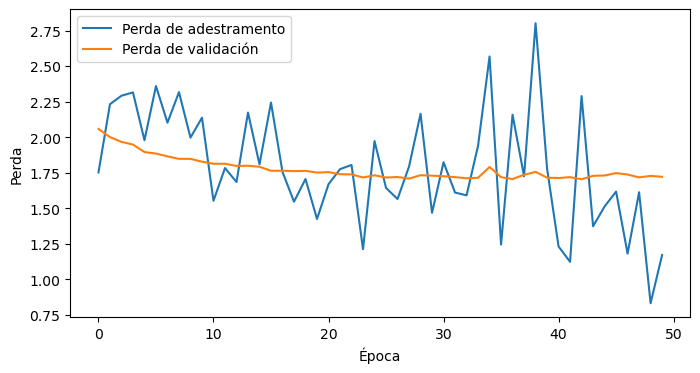

Perda media: 0.109201 Accuracy: 41.8%



In [ ]:
predicted,true=train_test(mlp)

Epoch 1
-------------------------------
perda: 2.351263  [    0/ 7575]
perda: 1.490350  [ 1600/ 7575]
perda: 1.488352  [ 3200/ 7575]
perda: 1.539522  [ 4800/ 7575]
perda: 1.563035  [ 6400/ 7575]
Epoch 2
-------------------------------
perda: 1.030890  [    0/ 7575]
perda: 1.781299  [ 1600/ 7575]
perda: 1.216379  [ 3200/ 7575]
perda: 0.930083  [ 4800/ 7575]
perda: 0.999619  [ 6400/ 7575]
Epoch 3
-------------------------------
perda: 0.932366  [    0/ 7575]
perda: 1.080275  [ 1600/ 7575]
perda: 1.143953  [ 3200/ 7575]
perda: 0.812189  [ 4800/ 7575]
perda: 0.772451  [ 6400/ 7575]
Epoch 4
-------------------------------
perda: 0.979683  [    0/ 7575]
perda: 0.728743  [ 1600/ 7575]
perda: 0.937455  [ 3200/ 7575]
perda: 0.575176  [ 4800/ 7575]
perda: 0.585308  [ 6400/ 7575]
Nonimprovement =  1
Epoch 5
-------------------------------
perda: 0.858550  [    0/ 7575]
perda: 0.736720  [ 1600/ 7575]
perda: 0.578740  [ 3200/ 7575]
perda: 0.947874  [ 4800/ 7575]
perda: 0.566335  [ 6400/ 7575]
Epoch

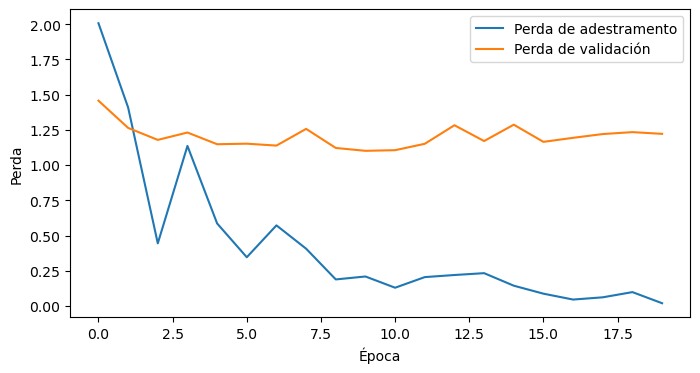

Perda media: 0.073615 Accuracy: 63.6%



In [67]:
#entrenamiento del cnn
predicted_cnn,true_cnn=train_test(cnn)

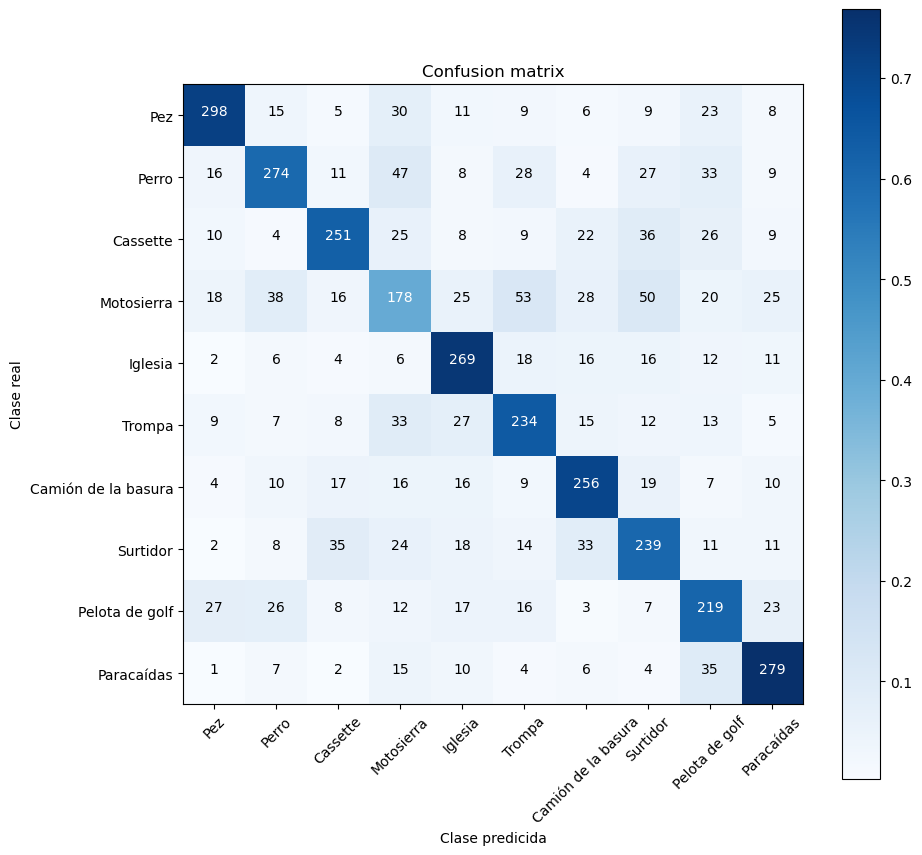

In [ ]:
labels_map = {
    0: "Pez",
    1: "Perro",
    2: "Cassette",
    3: "Motosierra",
    4: "Iglesia",
    5: "Trompa",
    6: "Camión de la basura",
    7: "Surtidor",
    8: "Pelota de golf",
    9: "Paracaídas",
}
plot_confusion_matrix(predicted_cnn,true_cnn, labels_map)

## Optimización MLP


In [ ]:
# Posibles combinaciones de capas ocultas para la MLP
hidden_layers_values = [
    [128],
    [256],
    [128, 64],
    [256, 128],
    [512, 256, 128],
    [1024, 512, 256, 128],
]

# Array de resultados
mlp_results = []

# Iterar sobre las configuraciones
for i, hidden_layers in enumerate(hidden_layers_values):
    
    print(f"\n**** CONFIGURACIÓN {i+1}: {hidden_layers} ****\n")

    mlp = MLP(
        input_neurons=128*128*3, # Cambiar en función de la resolución de la imagen
        output_neurons=10, # Las neuronas de salida son 10 porque hay 10 clases
        hidden_layers=hidden_layers
    )

    predicted_mlp, true_mlp = train_test(mlp)  

mlp_results.append({
    "hidden_layers": str(hidden_layers),
    "accuracy": accuracy_score(true_mlp, predicted_mlp),
    "recall": recall_score(true_mlp, predicted_mlp, average='macro', zero_division=0),
    "precision": precision_score(true_mlp, predicted_mlp, average='macro', zero_division=0),
    "f1": f1_score(true_mlp, predicted_mlp, zero_division=0, average='macro')
})


**** CONFIGURACIÓN 1: [128] ****


Epoch 1
-------------------------------
perda: 2.421261  [    0/ 7575]
perda: 2.108634  [ 1600/ 7575]


KeyboardInterrupt: 

In [ ]:
# Mostrar resultados ordenados por accuracy
mlp_df = pd.DataFrame(mlp_results)
display(mlp_df.sort_values(by="accuracy", ascending=False))

KeyError: 'accuracy'

## Optimización CNN

In [ ]:
# Parámetros a probar
conv_layers_values = [2, 3]
first_conv_filters_values = [16, 32]
conv_kernel_size_values = [3, 5]
batch_norm_values = [True, False]
hidden_mlp_layers_values = [[128], [256, 128]]

# Array de resultados
cnn_results = []

# Obtener todas las combinaciones de parámetros
combinaciones = list(itertools.product(
    conv_layers_values,
    first_conv_filters_values,
    conv_kernel_size_values,
    batch_norm_values,
    hidden_mlp_layers_values
))

# Bucle para probar combinaciones de parámetros
for i, (conv_layers, first_filters, kernel_size, batch_norm, mlp_layers) in enumerate(combinaciones):
    
    print(f"\n**** CONFIGURACIÓN {i+1}: conv_layers={conv_layers}, first_filters={first_filters}, kernel_size={kernel_size}, batch_norm={batch_norm}, mlp_layers={mlp_layers} ****\n")

    cnn = CNN(
        input_channels=3, # Cambiar según el número de canales de la imagen (RGB=3)
        conv_layers=conv_layers,
        first_conv_filters=first_filters,
        conv_kernel_size=kernel_size,
        batch_norm=batch_norm,
        hidden_mlp_layers=mlp_layers,
        output_neurons=10, # Cambiar según el número de clases
        input_size=[128, 128] # Cambiar en función del tamaño de la imagen de entrada
    )

    predicted_cnn, true_cnn = train_test(cnn)

    cnn_results.append({
        'conv_layers': conv_layers,
        'first_filters': first_filters,
        'kernel_size': kernel_size,
        'batch_norm': batch_norm,
        'mlp_layers': str(mlp_layers),
        "accuracy": accuracy_score(true_cnn, predicted_cnn),
        "recall": recall_score(true_cnn, predicted_cnn, average='macro', zero_division=0),
        "precision": precision_score(true_cnn, predicted_cnn, average='macro', zero_division=0),
        "f1": f1_score(true_cnn, predicted_cnn, zero_division=0, average='macro')

    })


**** CONFIGURACIÓN 1: conv_layers=2, first_filters=16, kernel_size=3, batch_norm=True, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.282923  [    0/ 7575]
perda: 1.861367  [ 1600/ 7575]
perda: 1.764696  [ 3200/ 7575]
perda: 1.820220  [ 4800/ 7575]


KeyboardInterrupt: 

In [ ]:
# Mostrar resultados ordenados por accuracy
cnn_df = pd.DataFrame(cnn_results)
display(cnn_df.sort_values(by="accuracy", ascending=False))